In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import osmnx
import networkx as nx
import tqdm

#%matplotlib notebook
%matplotlib inline

In [2]:
# I want to use stop sign directionality
osmnx.settings.useful_tags_node.extend(('stop', 'direction'))
# Force all ways to be oneway, so we preserve OSM order
# The graph is nearly undirected otherwise
osmnx.settings.all_oneway = True

In [3]:
#bbox_north = ...
#bbox_south = ...
#bbox_east = ...
#bbox_west = ...
#G_simple = osmnx.graph_from_bbox(bbox_north, bbox_south, bbox_east, bbox_west,
#                                 network_type='drive_service', simplify=True)
#osmnx.plot_graph(G_simple, node_size=20);

#G = osmnx.graph_from_bbox(bbox_north, bbox_south, bbox_east, bbox_west,
#                          network_type='drive_service', simplify=False)
#osmnx.plot_graph(G, node_size=20);

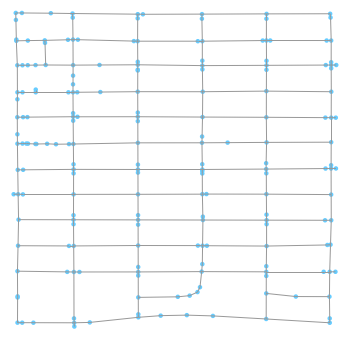

In [4]:
# Instead of pulling the graph from OSM, I saved the data to a file, normalized the lat/lon and such
G = nx.MultiDiGraph(nx.read_gexf('hood.gexf'))
G = nx.convert_node_labels_to_integers(G)
G.graph['name'] = 'unnamed'
G.graph['crs'] = osmnx.settings.default_crs
osmnx.plot_graph(G, node_size=20);

In [5]:
# Since we lied about everything being oneway, make an undirected version of the graph
Gu = G.to_undirected()

In [6]:
nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))
node_dict = dict(G.nodes(data=True))
edge_dict = {(e[0],e[1]): e[2] for e in edges}
uedge_dict = {(e[0],e[1]): e[2] for e in Gu.edges(data=True)}
uedge_dict.update({(e[1],e[0]): e[2] for e in Gu.edges(data=True)})

print('nodes:')
pprint(nodes[0:10], width=200, sort_dicts=False)
print('edges:')
pprint(edges[0:15], width=200, sort_dicts=False)

nodes:
[(0, {'x': 0.5045881447278184, 'y': 0.12533546325930117, 'label': '0'}),
 (1, {'x': 0.5650500384909988, 'y': 0.13990415335514694, 'label': '1'}),
 (2, {'x': 0.5778290993075647, 'y': 0.2027156549522587, 'highway': 'stop', 'stop': 'all', 'direction': 'both', 'label': '2'}),
 (3, {'x': 0.18337182448122044, 'y': 0.6780670926521871, 'label': '3'}),
 (4, {'x': 0.18327944572725408, 'y': 0.8363738019172787, 'highway': 'stop', 'stop': 'all', 'direction': 'both', 'label': '4'}),
 (5, {'x': 0.18290993071576453, 'y': 0.9148562300323572, 'label': '5'}),
 (6, {'x': 0.38173979984575596, 'y': 0.9927635782753209, 'highway': 'traffic_signals', 'label': '6'}),
 (7, {'x': 0.5788298691301664, 'y': 0.9929712460071071, 'label': '7'}),
 (8, {'x': 0.7770592763670343, 'y': 0.9936741214067368, 'label': '8'}),
 (9, {'x': 0.9721632024641416, 'y': 0.9940575079881467, 'label': '9'})]
edges:
[(0, 154, {'highway': 'service', 'length': 20.317, 'id': '0'}),
 (1, 155, {'highway': 'service', 'length': 11.25, 'id': 

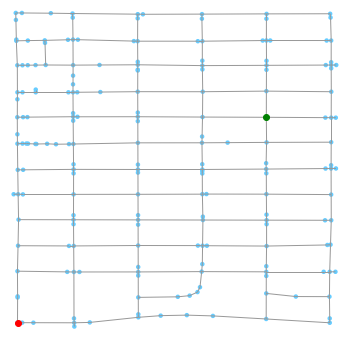

In [7]:
home_node = 17
exit_node = 13

annotate = False
osmnx.plot_graph(G, node_size=20, annotate=annotate, show=False, close=False)
plt.plot(node_dict[home_node]['x'], node_dict[home_node]['y'], 'go')
plt.plot(node_dict[exit_node]['x'], node_dict[exit_node]['y'], 'ro');

In [8]:
# Average speed when moving along a way
residential_speed = 9. # m/s ~ 20 mph
service_speed = 4.5 # m/s ~ 10 mph

# Time added for each stop sign encountered
# Note: this does a bad thing.  If we have a two-way stop, we'll count
# both the forward facing and backward facing stop sign.
stop_time = 5. # s

def metric(edge):
    node0, node1, data = edge
    
    length = float(data['length'])
    
    speed = residential_speed if data['highway'] == 'residential' else service_speed
    
    weight = length / speed
    
    if node0 in node_dict:
        node_data = node_dict[node0]
        if 'highway' in node_data and 'stop' in node_data['highway']:
            weight += stop_time
    
    return weight

def num_stops(path):
    stops = 0
    for p in path:
        node_data = node_dict[p]
        if 'highway' in node_data and 'stop' in node_data['highway']:
            stops += 1
    return stops


def path_time(path):
    t = 0.
    for e in nx.utils.pairwise(path):
        t += uedge_dict[e]['weight']
    return t

num_stops = 9
path len = 23
path time = 104.45255555555555


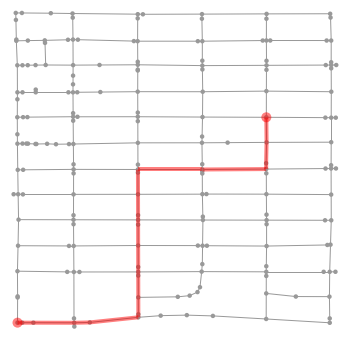

In [9]:
for e in Gu.edges(data=True):
    data = e[2]
    data['weight'] = metric(e)

path = nx.shortest_path(Gu, source=home_node, target=exit_node, weight='weight')
print('num_stops =', num_stops(path))
print('path len =', len(path))
print('path time =', path_time(path))
osmnx.plot.plot_graph_route(Gu, path, node_size=20);

In [10]:
# Let's try to do a better job of handling the stop signs.
# Additionally, how much slower is the next slowest path?
# Now the objective function is path dependent.  There aren't
# many edges in the graph, so let's just cook up all simple paths
# from the start to the exit? Then estimate the travel time along
# each path and take the top N.

# This part is quite slow...
all_paths = list(nx.simple_paths.all_simple_paths(Gu, home_node, exit_node, cutoff=30))

In [11]:
def path_time2(path):
    t = 0.
    for e in nx.utils.pairwise(path):
        node0, node1 = e
        
        e_in_edges = e in edge_dict
        traversal_direction = 'forward' if e_in_edges else 'backward'
        data = edge_dict[e] if e_in_edges else edge_dict[(e[1],e[0])]
        
        length = float(data['length'])
    
        speed = residential_speed if data['highway'] == 'residential' else service_speed
    
        t += length / speed
        
        # Add stop time only if we're facing the stop
        # The two-way stops have direction=forward/backward tags, but those don't appear
        # in the node or edge data.
        node0_data = node_dict[node0]
        if 'highway' in node0_data and node0_data['highway'] == 'stop':
            if 'stop' not in node0_data or node0_data['stop'] == 'all':
                t += stop_time
            
            elif node0_data['stop'] == 'minor':
                if traversal_direction == node0_data['direction']:
                    t += stop_time
    
    return t

all_paths.sort(key=lambda p: path_time2(p))

path time = 115.73344444444444
path = [17, 95, 131, 33, 51, 38, 56, 97, 84, 189, 55, 190, 91, 28, 122, 45, 134, 116, 13]


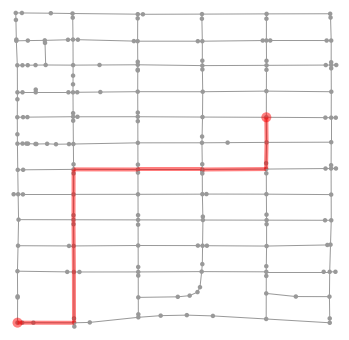

path time = 115.78655555555554
path = [17, 95, 131, 33, 51, 38, 174, 39, 175, 40, 55, 190, 91, 28, 122, 45, 134, 116, 13]


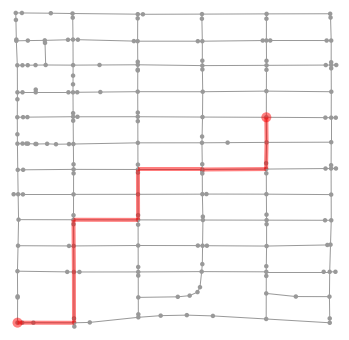

path time = 115.90699999999998
path = [17, 95, 131, 33, 51, 129, 168, 52, 96, 53, 40, 55, 190, 91, 28, 122, 45, 134, 116, 13]


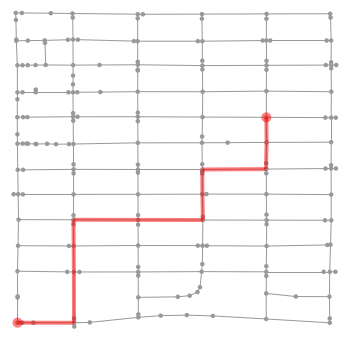

path time = 119.21055555555554
path = [17, 95, 131, 33, 51, 129, 168, 52, 96, 53, 83, 54, 2, 29, 185, 41, 119, 42, 46, 45, 134, 116, 13]


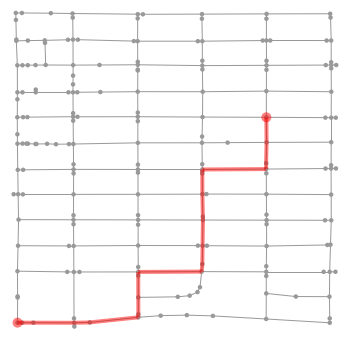

path time = 119.45255555555555
path = [17, 95, 131, 33, 51, 38, 174, 39, 175, 40, 183, 92, 184, 29, 185, 41, 119, 42, 46, 45, 134, 116, 13]


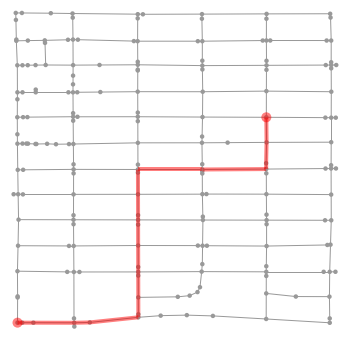

path time = 119.573
path = [17, 95, 131, 33, 51, 129, 168, 52, 96, 53, 40, 183, 92, 184, 29, 185, 41, 119, 42, 46, 45, 134, 116, 13]


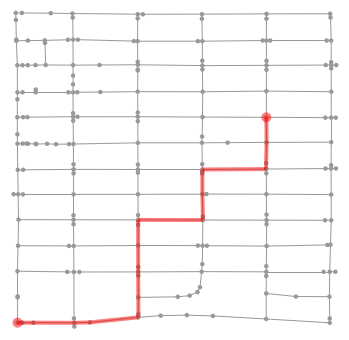

In [12]:
N = 6
for p in all_paths[:N]:
    print('path time =', path_time2(p))
    print('path =', p)
    osmnx.plot.plot_graph_route(Gu, p, node_size=20);

In [13]:
test_paths = {
    'path 1': ([17, 16, 136, 50, 167, 51, 129, 168, 52, 96, 53, 83, 54, 2, 29, 191, 28, 122, 45, 134, 116, 13], 122.0),
    'path 3': ([17, 158, 18, 94, 130, 21, 79, 22, 81, 23, 24, 121, 25, 36, 49, 48, 47, 42, 46, 45, 134, 116, 13], 135.0),
    'path 4': ([17, 16, 136, 50, 167, 51, 129, 168, 52, 96, 53, 83, 54, 2, 29, 191, 28, 122, 45, 134, 116, 13], 116.0),
    'path 6': ([17, 95, 131, 33, 178, 90, 179, 34, 180, 35, 181, 30, 182, 93, 36, 49, 48, 47, 42, 46, 45, 134, 116, 13], 115.0),
    'path 7': ([17, 95, 131, 33, 51, 38, 56, 97, 84, 189, 55, 190, 91, 28, 122, 45, 134, 116, 13], 113.0)
}

path 1
path time = 130.59377777777777
test time = 122.0


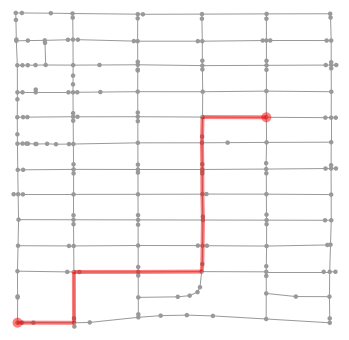

path 3
path time = 140.00688888888885
test time = 135.0


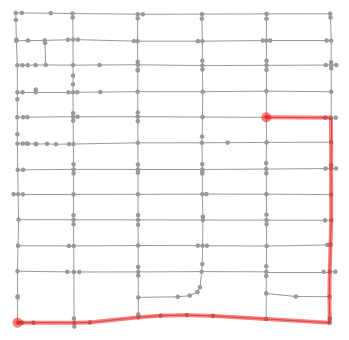

path 4
path time = 130.59377777777777
test time = 116.0


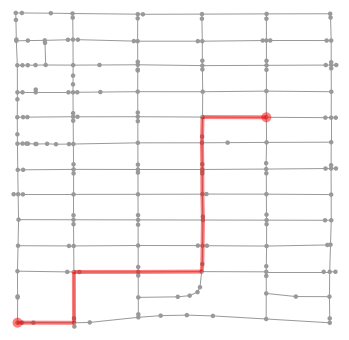

path 6
path time = 119.9242222222222
test time = 115.0


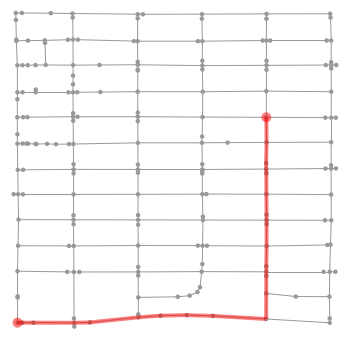

path 7
path time = 115.73344444444444
test time = 113.0


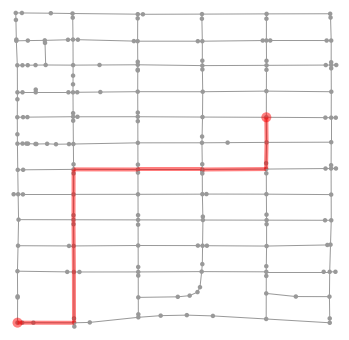

In [14]:
for k,t in test_paths.items():
    p, test_time = t
    print(k)
    print('path time =', path_time2(p))
    print('test time =', test_time)
    osmnx.plot.plot_graph_route(Gu, p, node_size=20);